# Kaggle Face Mask Types Dataset

### 사용 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import pathlib
import splitfolders


import PIL
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

### Data Load

In [2]:
total_img = glob.glob("Dataset/train/*/*")

print(f"Total Images: {len(total_img)}")

Total Images: 1956


In [3]:
total_img = pd.Series(total_img)
total_df = pd.DataFrame()
total_df["Filename"] = total_img.map(lambda img_name: img_name.split("\\")[-1])
total_df["ClassId"] = total_img.map(lambda img_name: img_name.split("\\")[-2])

total_df.head()

,Filename,ClassId
0,0.jpg,cloth
1,1.jpg,cloth
2,10.jpg,cloth
3,100.jpg,cloth
4,101.jpg,cloth


In [4]:
class_id_distributionTotal = total_df["ClassId"].value_counts()
class_id_distributionTotal

nfm      474
cloth    396
n95v     390
n95      354
srg      342
Name: ClassId, dtype: int64

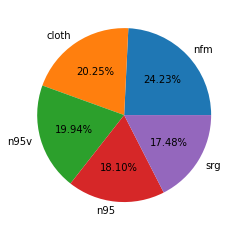

In [5]:
plt.figure(facecolor="white")
_ = plt.pie(class_id_distributionTotal.values, labels=class_id_distributionTotal.index, autopct="%.2f%%")

### Data Split

In [6]:
# Train : Test : Val = 80 : 10 : 10
splitfolders.ratio(input="Dataset/train/", output="output", ratio=(0.8, 0.1, 0.1))

Copying files: 1956 files [00:01, 1260.90 files/s]


In [7]:
train_img = glob.glob("./output/train/*/*")
test_img = glob.glob("./output/test/*/*")
val_img = glob.glob("./output/val/*/*")

print(f"\
training images: {len(train_img)}\n\
validation images: {len(val_img)}\n\
test images: {len(test_img)}\
    ")

training images: 1563
validation images: 194
test images: 199    


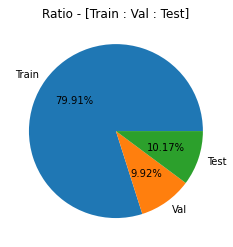

In [8]:
data = [len(train_img), len(val_img), len(test_img)]
labels = ["Train", "Val", "Test"]

plt.figure(facecolor="white")
_ = plt.pie(data, labels=labels, autopct="%.2f%%")
plt.title("Ratio - [Train : Val : Test]")
plt.show()

### Train / Validation / Test

In [9]:
# Train
train_image_names = pd.Series(train_img)
train_df = pd.DataFrame({"Filename":[x for x in train_image_names.map(lambda img_name: img_name.split("\\")[-1])],
                         "ClassId":[x for x in train_image_names.map(lambda img_name: img_name.split("\\")[-2])]})
# Val
val_image_names = pd.Series(val_img)
val_df = pd.DataFrame({"Filename":[x for x in val_image_names.map(lambda img_name: img_name.split("\\")[-1])],
                         "ClassId":[x for x in val_image_names.map(lambda img_name: img_name.split("\\")[-2])]})
# Test
test_image_names = pd.Series(test_img)
test_df = pd.DataFrame({"Filename":[x for x in test_image_names.map(lambda img_name: img_name.split("\\")[-1])],
                         "ClassId":[x for x in test_image_names.map(lambda img_name: img_name.split("\\")[-2])]})

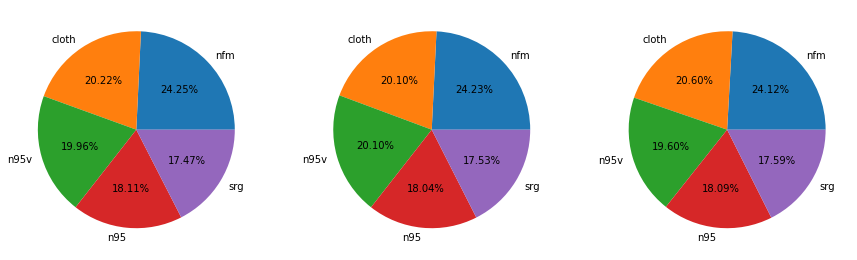

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for idx, df in enumerate([train_df, val_df, test_df]):
    axex = ax[idx]
    df = df["ClassId"].value_counts()
    axex.pie(df.values, labels=df.index, autopct="%.2f%%")
plt.show()

### Show Image

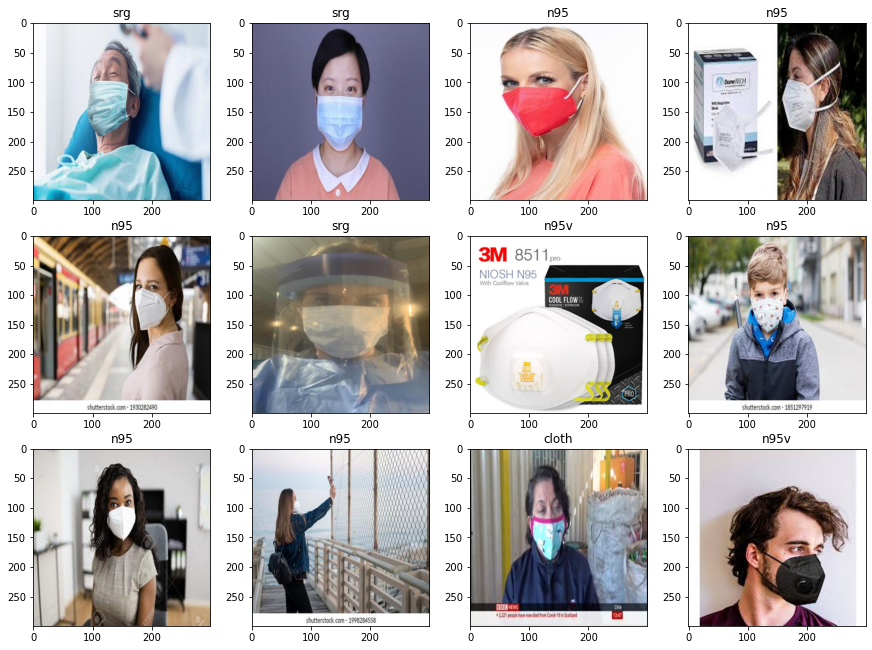

In [14]:
plot_df = train_df.sample(12).reset_index()
plt.figure(figsize=(15, 15))

for _ in range(12):
    img_name = plot_df.loc[_, "Filename"]
    label_str = plot_df.loc[_, "ClassId"]
    plt.subplot(4, 4, _+1)
    plt.imshow(plt.imread(os.path.join("./output/train/", label_str, img_name)))
    plt.title(label_str)

### Image Data Generator

In [25]:
train_datagen = ImageDataGenerator(zoom_range=0.15, width_shift_range=0.2, shear_range=0.15)
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory("./output/train/", target_size=(300, 300), batch_size=32, shuffle=True, class_mode='categorical')
test_generator = test_datagen.flow_from_directory("./output/test/", target_size=(300,300), batch_size=32, shuffle=False, class_mode='categorical')
val_generator = val_datagen.flow_from_directory("./output/val/", target_size=(300,300), batch_size=32, shuffle=False, class_mode='categorical')

Found 1563 images belonging to 5 classes.
Found 199 images belonging to 5 classes.
Found 194 images belonging to 5 classes.


### Modeling - Efficent Net

In [26]:
from tensorflow.keras.applications import EfficientNetB0

model = EfficientNetB0(
    input_shape=(300, 300, 3),
    include_top=False,
    weights="imagenet"
)

#### Fine Tuning

In [27]:
model.trainable = True

for layer in model.layers[:-15]:
    layer.trainable = False
    
x = tf.keras.layers.Flatten()(model.output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(5, activation="softmax")(x)

model = tf.keras.Model(model.input, x)

model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ["accuracy"]
)

### Train

In [28]:
early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", verbose=0, patience=20)
# model_check = ModelCheckpoint("model.h5", monitor="val_accuracy", mode="max", save_best_only=True)

In [30]:
with tf.device("/device:GPU:0"):
    history = model.fit(train_generator, validation_data=val_generator, epochs=50, verbose=1, callbacks=[early_stopping])

Epoch 1/50
49/49 [==============================] - 25s 517ms/step - loss: 0.3727 - accuracy: 0.9469 - val_loss: 0.9907 - val_accuracy: 0.8918
Epoch 2/50
49/49 [==============================] - 26s 521ms/step - loss: 0.2210 - accuracy: 0.9623 - val_loss: 0.9097 - val_accuracy: 0.9021
Epoch 3/50
49/49 [==============================] - 26s 522ms/step - loss: 0.3565 - accuracy: 0.9584 - val_loss: 0.9695 - val_accuracy: 0.9175
Epoch 4/50
49/49 [==============================] - 26s 523ms/step - loss: 0.1329 - accuracy: 0.9776 - val_loss: 0.9103 - val_accuracy: 0.9330
Epoch 5/50
49/49 [==============================] - 26s 520ms/step - loss: 0.3420 - accuracy: 0.9623 - val_loss: 1.0402 - val_accuracy: 0.9433
Epoch 6/50
49/49 [==============================] - 26s 523ms/step - loss: 0.2606 - accuracy: 0.9699 - val_loss: 1.4506 - val_accuracy: 0.9227
Epoch 7/50
49/49 [==============================] - 26s 521ms/step - loss: 0.2862 - accuracy: 0.9687 - val_loss: 1.8153 - val_accuracy: 0.9330

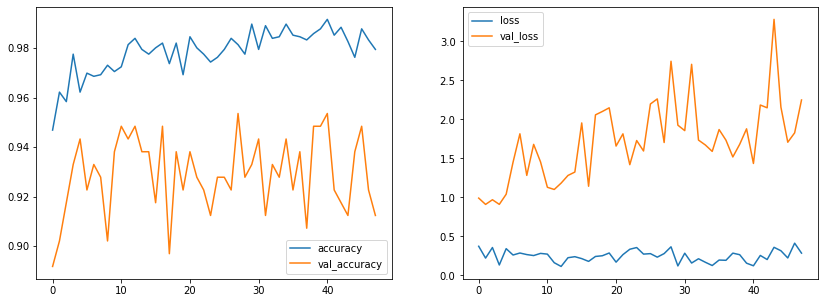

In [31]:
hist_df = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
hist_df[["accuracy", "val_accuracy"]].plot(ax=ax[0])
hist_df[["loss", "val_loss"]].plot(ax=ax[1])
plt.show()

### Model Evaliation

In [32]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

7/7 [==============================] - 3s 332ms/step - loss: 4.2478 - accuracy: 0.8995
Loss: 424.777
Accuracy: 89.950


In [33]:
y_val = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred,axis=1)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86        41
           1       0.91      0.81      0.85        36
           2       0.86      0.95      0.90        39
           3       0.96      1.00      0.98        48
           4       0.88      0.86      0.87        35

    accuracy                           0.90       199
   macro avg       0.90      0.89      0.89       199
weighted avg       0.90      0.90      0.90       199

